Adapted code from  https://github.com/lorenlugosch/pytorch_HMM

In [1]:
import torch
import numpy as np

class GM_HMM(torch.nn.Module):
  """
  Gaussian Mixture Hidden Markov Model with discrete observations.
  """
  def __init__(self, M, N, mean, cov):
    super(GM_HMM, self).__init__()
    self.M = M # number of possible observations
    self.N = N # number of states

    # A
    self.transition_model = TransitionModel(self.N)

    # b(x_t)
    self.emission_model = EmissionModel(self.N,self.M, mean, cov)

    # pi
    self.unnormalized_state_priors = torch.nn.Parameter(torch.randn(self.N))

    # use the GPU
    self.is_cuda = torch.cuda.is_available()
    if self.is_cuda: self.cuda()

class TransitionModel(torch.nn.Module):
  def __init__(self, N):
    super(TransitionModel, self).__init__()
    self.N = N
    self.unnormalized_transition_matrix = torch.nn.Parameter(torch.randn(N,N))

class EmissionModel(torch.nn.Module):
  def __init__(self, N, M, mean=None, cov=None):
    super(EmissionModel, self).__init__()
    self.N = N
    self.M = M
    self.mean = torch.nn.ParameterList()
    self.cov = torch.nn.ParameterList()
    for i in range(self.N):
      self.mean.append(torch.nn.Parameter(mean[i,:],requires_grad=False))
      self.cov.append(torch.nn.Parameter(cov[i], requires_grad=False))
   
  def forward(self, x):
    from torch.distributions.multivariate_normal import MultivariateNormal
    probs = torch.stack([MultivariateNormal(self.mean[i],self.cov[i]).log_prob(x) for i in range(self.N)])
    return torch.nn.LogSoftmax(dim=0)(probs)

In [2]:
def HMM_forward(self, x, T):
    """
    x : IntTensor of shape (batch size, T_max)
    T : IntTensor of shape (batch size)

    Compute log p(x) for each example in the batch.
    T = length of each example
    """
    if self.is_cuda:
        x = x.cuda()
        T = T.cuda()

    batch_size = T; T_max = x.shape[0]
    log_state_priors = torch.nn.functional.log_softmax(self.unnormalized_state_priors, dim=0)
    log_alpha = torch.zeros(batch_size, T_max, self.N)
    if self.is_cuda: log_alpha = log_alpha.cuda()

    log_alpha[:, 0, :] = self.emission_model(x[0,0]) + log_state_priors
    for t in range(1, T_max):
        log_alpha[:, t, :] = self.emission_model(x[0,t]) + self.transition_model(log_alpha[:, t-1, :])
        if t%100000 == 0: print("t:", t)

    # Select the sum for the final timestep (each x may have different length).
    log_sums = log_alpha.logsumexp(dim=2)
    log_probs = torch.gather(log_sums, 1, T.view(-1,1) - 1)
    return log_probs

def transition_model_forward(self, log_alpha):
    """
    log_alpha : Tensor of shape (batch size, N)
    Multiply previous timestep's alphas by transition matrix (in log domain)
    """
    log_transition_matrix = torch.nn.functional.log_softmax(self.unnormalized_transition_matrix, dim=0)

    # Matrix multiplication in the log domain
    out = log_domain_matmul(log_transition_matrix, log_alpha.transpose(0,1)).transpose(0,1)
    return out

def log_domain_matmul(log_A, log_B):
    """
    log_A : m x n
    log_B : n x p
    output : m x p matrix

    Normally, a matrix multiplication
    computes out_{i,j} = sum_k A_{i,k} x B_{k,j}

    A log domain matrix multiplication
    computes out_{i,j} = logsumexp_k log_A_{i,k} + log_B_{k,j}
    """
    m = log_A.shape[0]
    n = log_A.shape[1]
    p = log_B.shape[1]

    # log_A_expanded = torch.stack([log_A] * p, dim=2)
    # log_B_expanded = torch.stack([log_B] * m, dim=0)
    # fix for PyTorch > 1.5 by egaznep on Github:
    log_A_expanded = torch.reshape(log_A, (m,n,1))
    log_B_expanded = torch.reshape(log_B, (1,n,p))

    elementwise_sum = log_A_expanded + log_B_expanded
    out = torch.logsumexp(elementwise_sum, dim=1)

    return out

TransitionModel.forward = transition_model_forward
GM_HMM.forward = HMM_forward

In [3]:
import torch.utils.data
from collections import Counter
from sklearn.model_selection import train_test_split

class PeaksDataset(torch.utils.data.Dataset):
  def __init__(self, bed):
    super().__init__()
    self.bed = bed # list of strings
    collate = Collate() # function for generating a minibatch from strings
    self.loader = torch.utils.data.DataLoader(self, batch_size=1, sampler = sampleChr(self.bed), num_workers=0, collate_fn=collate)

  def __len__(self):
    return torch.tensor(len(self.bed.chr.unique()))

  def __iter__(self):
    for chr in self.bed.chr.unique():
      batch = np.where(self.bed.chr == chr)[0]
      batch = batch.astype(int)
      yield batch
  
  def __getitem__(self, idx):
    line = self.bed.iloc[idx,4:].to_numpy().astype(float)
    return line

class sampleChr(torch.utils.data.SequentialSampler):
  def __init__(self, data_source):
    self.data_source = data_source

  def __iter__(self):
    for chr in self.data_source.chr.unique():
      batch = np.where(self.data_source.chr == chr)[0]
      batch = batch.astype(int)
      yield batch

  def __len__(self):
    return torch.tensor(len(self.data_source.chr.unique()))
  

class Collate:
  def __init__(self):
    pass

  def __call__(self, batch):
    """
    Returns a minibatch of strings, padded to have the same length.
    """
    # stack into single tensor
    x = torch.tensor(batch)
    x_lengths = torch.tensor(1)
    return x,x_lengths

In [4]:

from tqdm import tqdm # for displaying progress bar

class Trainer:
  def __init__(self, model, lr):
    self.model = model
    self.lr = lr
    self.optimizer = torch.optim.Adam(model.parameters(), lr=self.lr, weight_decay=0.00001)
  
  def train(self, dataset):
    train_loss = 0
    num_samples = 0
    self.model.train()
    print_interval = 10
    for idx, batch in enumerate(tqdm(dataset.loader)):
      x,T = batch
      batch_size = 1
      num_samples += batch_size
      log_probs = self.model(x,T)
      loss = 1-log_probs.mean().exp()
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()
      train_loss += loss.cpu().data.numpy().item() * batch_size
      # if idx % print_interval == 0:
      #   print("loss:", loss.item())
      #   for _ in range(5):
      #     sampled_x, sampled_z = self.model.sample()
      #     #print(decode(sampled_x))
      #     print(sampled_x)
      #     print(sampled_z)
    #print("loss:", loss.item())
    # for _ in range(5):
    #   sampled_x, sampled_z = self.model.sample()
    #   #print(decode(sampled_x))
    #   print(sampled_x)
    #   print(sampled_z)      
    train_loss /= num_samples
    return train_loss

  def test(self, dataset):
    test_loss = 0
    num_samples = 0
    self.model.eval()
    # print_interval = 10
    for idx, batch in enumerate(dataset.loader):
      x,T = batch
      batch_size = 1
      num_samples += batch_size
      log_probs = self.model(x,T)
      loss = 1-log_probs.mean().exp()
      test_loss += loss.cpu().data.numpy().item() * batch_size
      # if idx % print_interval == 0:
      #   print("loss:", loss.item())
      #   sampled_x, sampled_z = self.model.sample()
      #   #print(decode(sampled_x))
      #   print(sampled_x)
      #   print(sampled_z)
    #print("loss:", loss.item())
    # sampled_x, sampled_z = self.model.sample()
    # #print(decode(sampled_x))
    # print(sampled_x)
    # print(sampled_z)   
    test_loss /= num_samples
    return test_loss

In [5]:
import pandas as pd
from sklearn.mixture import GaussianMixture
import os

dir = '/Users/fionshiau/Documents/2023Spring/Computational_Genomics/Final_Project/comp-geno-proj/'
lines = pd.read_csv(os.path.join(dir,'data','merged','1.3.1_raw.csv'))
mat = lines.iloc[:,4:].to_numpy()

from sklearn.preprocessing import Normalizer
mat = np.hstack((mat[:,0].reshape(-1,1),Normalizer().fit_transform(X=mat[:,1:])))
gm = GaussianMixture(n_components = 7, random_state=0).fit(mat)

lines.iloc[:,4:] = mat



In [7]:
train_lines, valid_lines = train_test_split(lines.chr.unique(), test_size=0.1, random_state=0)
train_dataset = PeaksDataset(lines.loc[lines.chr.isin(train_lines),:])
valid_dataset = PeaksDataset(lines.loc[lines.chr.isin(valid_lines),:])

M = lines.iloc[:,4:].shape[1]

In [8]:
# Initialize model
model = GM_HMM(N=7, M=M,mean = torch.from_numpy(gm.means_), cov = torch.from_numpy(gm.covariances_))

In [9]:

# Train the model
num_epochs = 100
trainer = Trainer(model, lr=0.1)
past_loss = []
for epoch in range(num_epochs):
    print("========= Epoch %d of %d =========" % (epoch+1, num_epochs))
    train_loss = trainer.train(train_dataset)
    valid_loss = trainer.test(valid_dataset)

    print("========= Results: epoch %d of %d =========" % (epoch+1, num_epochs))
    print("train loss: %.2f| valid loss: %.2f\n" % (train_loss, valid_loss))
    past_loss.append(train_loss)
    if len(past_loss) > 1:
        loss_change = past_loss[-2]-past_loss[-1]
    else:
        loss_change = 1
        
    if train_loss < 0.0001 or loss_change<0.001:
        break

========= Epoch 1 of 100 =========


  0%|          | 0/19 [00:00<?, ?it/s]/var/folders/zb/k8zh8whx36g93snxwz8xsqq00000gn/T/ipykernel_17242/2135782770.py:48: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1680607561775/work/torch/csrc/utils/tensor_new.cpp:248.)
  x = torch.tensor(batch)
100%|██████████| 19/19 [00:01<00:00,  9.92it/s]


========= Results: epoch 1 of 100 =========
train loss: 0.78| valid loss: 0.39

========= Epoch 2 of 100 =========


100%|██████████| 19/19 [00:01<00:00, 13.15it/s]


========= Results: epoch 2 of 100 =========
train loss: 0.18| valid loss: 0.02

========= Epoch 3 of 100 =========


100%|██████████| 19/19 [00:01<00:00, 13.58it/s]


========= Results: epoch 3 of 100 =========
train loss: 0.06| valid loss: 0.01

========= Epoch 4 of 100 =========


100%|██████████| 19/19 [00:01<00:00, 13.46it/s]


========= Results: epoch 4 of 100 =========
train loss: 0.06| valid loss: 0.01

========= Epoch 5 of 100 =========


100%|██████████| 19/19 [00:01<00:00, 13.57it/s]


========= Results: epoch 5 of 100 =========
train loss: 0.06| valid loss: 0.00

========= Epoch 6 of 100 =========


100%|██████████| 19/19 [00:01<00:00, 11.74it/s]


========= Results: epoch 6 of 100 =========
train loss: 0.06| valid loss: 0.00



<Axes: >

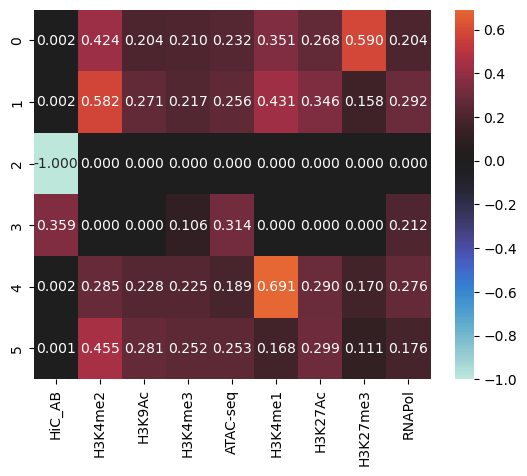

In [220]:
import seaborn as sns
sns.heatmap(pd.DataFrame(gm.means_,columns = train.columns[4:]),center=0,annot=True,fmt='.3f')

In [12]:
tr_sig = torch.softmax(model.transition_model.unnormalized_transition_matrix,dim=0).detach().clone()

In [188]:
tr_sig

tensor([[0.0587, 0.1660, 0.1780, 0.1783, 0.2238, 0.1951],
        [0.0512, 0.2071, 0.0864, 0.1714, 0.1088, 0.3751],
        [0.2513, 0.0589, 0.1699, 0.1491, 0.1782, 0.1925],
        [0.0659, 0.0803, 0.1657, 0.0242, 0.1124, 0.5515],
        [0.2465, 0.0406, 0.0761, 0.4086, 0.1642, 0.0640],
        [0.2216, 0.0755, 0.1324, 0.0605, 0.0761, 0.4339]])

<Axes: >

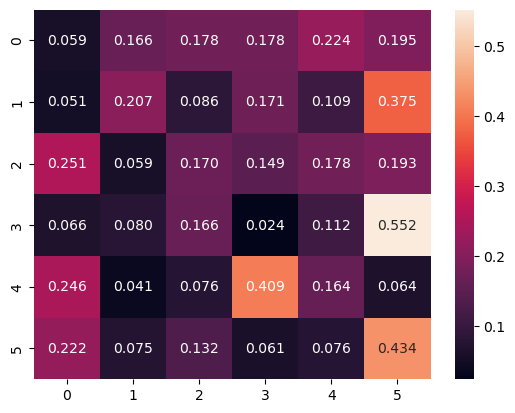

In [222]:
sns.heatmap(pd.DataFrame(tr_sig), annot=True,fmt='.3f')

In [14]:
torch.softmax(model.unnormalized_state_priors,dim=0).detach().clone().numpy()

array([1.3176486e-04, 3.7687650e-04, 8.9866022e-05, 9.9643159e-01,
       1.0227023e-03, 1.5505475e-03, 3.9651545e-04], dtype=float32)

<Axes: >

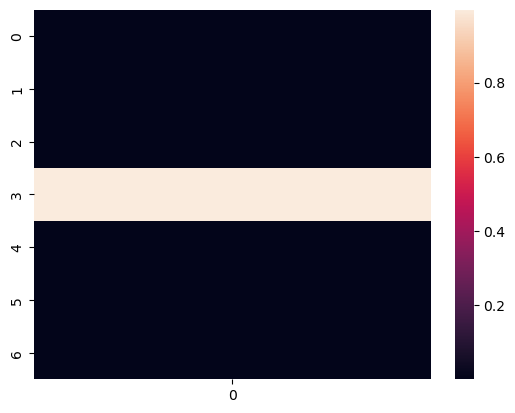

In [15]:
sns.heatmap(torch.softmax(model.unnormalized_state_priors,dim=0).detach().clone().numpy().reshape(-1,1))

## Predicting RNA Pol Binding

In [6]:
import torch
import numpy as np

class pred_RNA(torch.nn.Module):
  def __init__(self, N, M, mean=None, cov=None):
    from torch.distributions.multivariate_normal import MultivariateNormal
    super(pred_RNA, self).__init__()
    self.N = N
    self.M = M
    self.mean = torch.nn.ParameterList()
    self.cov = torch.nn.ParameterList()
    for i in range(self.N):
      self.mean.append(torch.nn.Parameter(mean[i,:],requires_grad=False))
      self.cov.append(torch.nn.Parameter(cov[i], requires_grad=False))
    self.dist = [MultivariateNormal(self.mean[i][:-1],self.cov[i][:-1,:-1]) for i in range(self.N)]
    self.dist_full = [MultivariateNormal(self.mean[i],self.cov[i]) for i in range(self.N)]
  
  def label(self,x):
    probs = torch.stack([self.dist[i].log_prob(x) for i in range(self.N)])
    return probs.max(dim=0)[1]
    
  def forward(self, x):
    label = self.label(x) # predict state using truncated covariance matrix
    C = self.dist_full[label].covariance_matrix # get covariance matrix from state
    P = self.dist[label].precision_matrix # get inverse of truncated covariance matrix
    m = self.dist_full[label].mean # mean of each marker
    pred = m[-1] + (C[-1,:-1]@P@(x-m[:-1]).reshape(-1,1)) # infer RNA using multivariate normal distribution
    return label, pred

In [7]:
gm

GaussianMixture(n_components=7, random_state=0)

In [9]:
#gm = GaussianMixture(n_components = 11, random_state=0).fit(mat)
pred = pred_RNA(N=7, M=lines.iloc[:,4:].shape[1],mean = torch.from_numpy(gm.means_), cov = torch.from_numpy(gm.covariances_))

In [ ]:
# Train the model
from tqdm import notebook
data = torch.tensor(mat)
test = []
test_labs = []
for index, r in enumerate(notebook.tqdm(data)):
    l, t = pred(r[:-1])
    test_labs.append(l)
    test.append(t)

  0%|          | 0/576216 [00:00<?, ?it/s]

In [631]:
test

[tensor([3.9847e-144], dtype=torch.float64),
 tensor([-0.0383], dtype=torch.float64),
 tensor([0.0056], dtype=torch.float64),
 tensor([1.8700], dtype=torch.float64),
 tensor([1.0579e-143], dtype=torch.float64),
 tensor([0.1399], dtype=torch.float64),
 tensor([1.6673], dtype=torch.float64),
 tensor([1.0285e-143], dtype=torch.float64),
 tensor([1.0328e-143], dtype=torch.float64),
 tensor([1.0604e-143], dtype=torch.float64),
 tensor([1.5262], dtype=torch.float64),
 tensor([0.5231], dtype=torch.float64),
 tensor([1.2600], dtype=torch.float64),
 tensor([-0.0342], dtype=torch.float64),
 tensor([0.6345], dtype=torch.float64),
 tensor([-0.0127], dtype=torch.float64),
 tensor([0.4900], dtype=torch.float64),
 tensor([-0.0162], dtype=torch.float64),
 tensor([1.1914], dtype=torch.float64),
 tensor([6.1825e-144], dtype=torch.float64),
 tensor([1.7493], dtype=torch.float64),
 tensor([0.0550], dtype=torch.float64),
 tensor([-0.0486], dtype=torch.float64),
 tensor([0.3814], dtype=torch.float64),
 tens

In [ ]:
torch.nn.functional.mse_loss(torch.stack(test),data[:,-1])

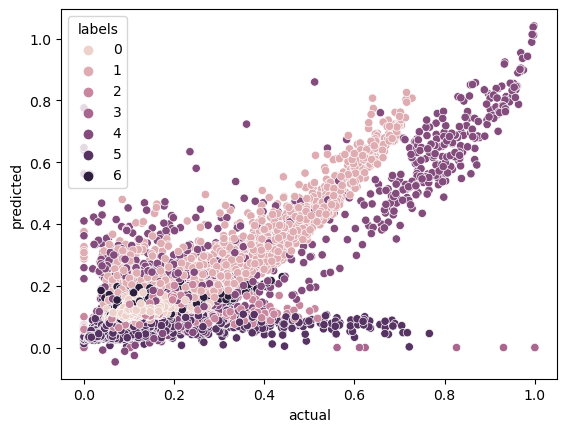

In [645]:
g = sns.scatterplot(pd.DataFrame({'actual':data[:,-1], 
                                  'predicted': torch.stack(test).numpy().reshape(-1),
                                  'labels' : torch.stack(test_labs).numpy().reshape(-1)}),
                    x='actual',y='predicted',hue='labels')



In [124]:
from scipy.stats import pearsonr
pearsonr(test.numpy().reshape(-1),mat[:,-1])

PearsonRResult(statistic=0.6509604817137322, pvalue=0.0)

### Test model on only promoters

In [69]:
prom = pd.read_csv('/Users/fionshiau/Library/CloudStorage/GoogleDrive-fioncshiau@gmail.com/.shortcut-targets-by-id/1lFT97diQ46tMlkSXaFO_BmMQeibiSn-H/ComputationalGenomics/PromotersSignal/merged_allData_promoters.csv')

In [104]:
prom.shape

(29200, 58)

In [71]:
prom.columns

Index(['Unnamed: 0', 'chr', 'start', 'end', 'H3K9Ac', 'H3K9Ac.1', 'H3K9Ac.2',
       'H3K9Ac.3', 'H3K9Ac.4', 'H3K9Ac.5', 'RNAPol', 'RNAPol.1', 'RNAPol.2',
       'RNAPol.3', 'RNAPol.4', 'RNAPol.5', 'RNAPol.6', 'RNAPol.7', 'RNAPol.8',
       'H3K4me3', 'H3K4me3.1', 'H3K4me3.2', 'H3K4me3.3', 'H3K4me3.4',
       'H3K4me3.5', 'H3K4me3.6', 'H3K4me3.7', 'H3K4me3.8', 'HiC_AB',
       'HiC_AB.1', 'HiC_AB.2', 'HiC_AB.3', 'H3K4me2', 'H3K4me2.1', 'H3K4me2.2',
       'H3K27me3', 'H3K27me3.1', 'H3K27me3.2', 'H3K27me3.3', 'H3K27me3.4',
       'H3K27me3.5', 'H3K27me3.6', 'H3K4me1', 'H3K4me1.1', 'H3K4me1.2',
       'H3K4me1.3', 'H3K4me1.4', 'H3K4me1.5', 'ATAC-seq', 'ATAC-seq.1',
       'ATAC-seq.2', 'ATAC-seq.3', 'ATAC-seq.4', 'ATAC-seq.5', 'ATAC-seq.6',
       'H3K27Ac', 'H3K27Ac.1', 'H3K27Ac.2'],
      dtype='object')

In [72]:
dat.columns

Index(['Unnamed: 0', 'chr', 'start', 'end', 'HiC_AB', 'H3K4me2', 'H3K9Ac',
       'H3K4me3', 'ATAC-seq', 'H3K4me1', 'H3K27Ac', 'H3K27me3', 'RNAPol'],
      dtype='object')

In [115]:
prom_1 = prom.loc[:,['HiC_AB', 'H3K4me2', 'H3K9Ac','H3K4me3', 'ATAC-seq', 'H3K4me1', 'H3K27Ac', 'H3K27me3', 'RNAPol']].to_numpy()

In [116]:
from sklearn.preprocessing import normalize
prom_1=normalize(X=prom_1, axis=1, norm='l2')

In [117]:
# Test the model
from tqdm.notebook import tqdm
prom_dat = torch.tensor(prom_1).type(torch.float32)
prom_test = torch.empty(size=(prom_dat.shape[0],1))
prom_test_labs = torch.empty(size=(prom_dat.shape[0],1))
for idx, r in tqdm(enumerate(prom_dat),total=prom_dat.shape[0]):
    prom_test[idx],prom_test_labs[idx] = pred.predict(r[:-1],keep_lab=True)


  0%|          | 0/29200 [00:00<?, ?it/s]

In [166]:
prom_test_labs.mode(axis=0)

torch.return_types.mode(
values=tensor([5.]),
indices=tensor([21900]))

In [118]:
torch.nn.functional.mse_loss(prom_test,prom_dat[:,-1].reshape(-1,1))

tensor(0.0303)

[(0.0, 1.1), (-0.05, 1.0)]

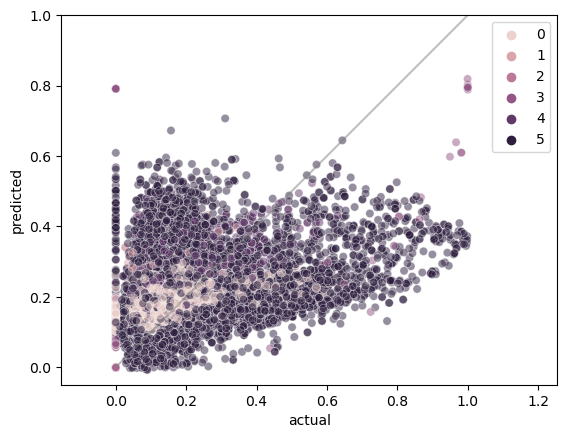

In [145]:
import seaborn as sns
rng = np.random.default_rng(0)
sample_indices = rng.choice(prom_1.shape[0],size=10000)
g = sns.scatterplot(pd.DataFrame({'actual':prom_1[sample_indices,-1], 
                                  'predicted': prom_test[sample_indices].numpy().reshape(-1),
                                  'labels' : prom_test_labs[sample_indices].numpy().astype(int).reshape(-1)}),
                    x='actual',y='predicted',hue='labels',alpha=.5)
sns.lineplot(x = np.arange(0,1.1,.1),y=np.arange(0,1.1,.1), color = 'grey', alpha = .5)
g.axis('equal')
g.set(xlim=(0, 1.1), ylim=(-0.05, 1))



In [128]:
pearsonr(prom_test.numpy().reshape(-1),prom_dat[:,-1])

PearsonRResult(statistic=0.2737293381939389, pvalue=0.0)